<a href="https://colab.research.google.com/github/fred-lafleche/Exchange/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [11]:
#imports
from sklearn import preprocessing
from sklearn import tree
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plot
from sklearn.utils import resample
from scipy.sparse import coo_matrix
from sklearn.utils import resample
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
shoppersInput_file= "/content/drive/MyDrive/Colab Notebooks/online_shoppers_intention.csv"
heartInput_file = "/content/drive/MyDrive/Colab Notebooks/heart.csv"
marketingInput_file = "/content/drive/MyDrive/Colab Notebooks/marketing_campaign.csv"

shopDataPd = pd.read_csv(shoppersInput_file)
heartDataPd = pd.read_csv(heartInput_file)
marketDataPd = pd.read_csv(marketingInput_file)
print("Shopper Data: \n",shopDataPd.head())
print("\nHeart Data: \n",heartDataPd.head())
print("\nMarket Campaing Data: \n",marketDataPd.head())


Shopper Data: 
    Administrative  Administrative_Duration  ...  Weekend  Revenue
0               0                      0.0  ...    False    False
1               0                      0.0  ...    False    False
2               0                      0.0  ...    False    False
3               0                      0.0  ...    False    False
4               0                      0.0  ...     True    False

[5 rows x 18 columns]

Heart Data: 
    age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0   0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]

Market Campaing Data: 
     

#Preprocessing

Online Shoppers Intention

In [13]:
# Normalization
dataArray = shopDataPd.values
np.random.shuffle(dataArray)
numericData = dataArray[:,[0,1,2,3,4,5,6,7,8,9]]
scaler = preprocessing.StandardScaler().fit(numericData)
scalledNumericData = scaler.transform(numericData)

# One hot encoding
categoricalData = dataArray[:,[10,15,16]]
categoricalLabel = dataArray[:,[17]]
encoder1 = preprocessing.OneHotEncoder()
encoder2 = preprocessing.OneHotEncoder()
encoder1.fit(categoricalData)
encoder2.fit(categoricalLabel)
categoricalData=encoder1.transform(categoricalData).toarray()
categoricalLabel = encoder2.transform(categoricalLabel).toarray()

#join data back together
shopData = np.column_stack((scalledNumericData, categoricalData))
#add back columns 11 to 14 and 17
shopData = np.column_stack((shopData, dataArray[:,[11,12,13,14]]))
shopLabel = categoricalLabel[:,[1]]

Heart Data

In [14]:
heartDataArray = heartDataPd.values
np.random.shuffle(heartDataArray)
print(heartDataArray.size)
heartData = np.delete(heartDataArray, 13, 1)
print(heartData.size)
heartLabel = heartDataArray[:,[13]]
print(heartLabel.size)

4242
3939
303


Marketing Campaign

In [15]:
marketDataArray = marketDataPd.values
np.random.shuffle(marketDataArray)
print(marketDataArray.size)
marketLabel = marketDataArray[:,[6]] #label
marketData = np.delete(marketDataArray, 6, 1) #remove label
marketData = np.delete(marketData, 6, 1) #date
marketData = np.delete(marketData, 3, 1) #Marital Status
marketData = np.delete(marketData, 2, 1) #Education

# Normalization and remove nan with mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(marketData)
marketData=imp.transform(marketData)

scalerMarket = preprocessing.StandardScaler().fit(marketData)
scalledMarketData = scalerMarket.transform(marketData)

# One hot encoding
categoricalMarketData = marketDataArray[:,[2,3]]
encoder = preprocessing.OneHotEncoder()
encoder.fit(categoricalMarketData)
categoricalMarketData=encoder.transform(categoricalMarketData).toarray()

encoder = preprocessing.OneHotEncoder()
encoder.fit(marketLabel)
marketLabel=encoder.transform(marketLabel).toarray()
marketLabel = marketLabel[:,[0]] #1 for absence

#join data back together
marketData = np.column_stack((scalledMarketData, categoricalMarketData))

print(marketData[100])
print(marketLabel[0])
print(marketLabel[1])
print(marketLabel[2])
print(marketData.size)

print(marketLabel.size)

64960
[-0.67966801  1.93585122 -0.69159906 -0.82521765  0.7559965  -0.80213333
 -0.56085708 -0.44734455 -0.63213986 -0.41343387 -0.46057923 -0.68588662
 -0.75045033 -0.56871962 -0.55078479  0.69390374 -0.28014028 -0.28383019
 -0.28014028 -0.26211122 -0.11651035 -0.09728167  0.          0.
 -0.41861211  0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
[0.]
[0.]
[0.]
85120
2240


# Dividing the data into training and testing

In [16]:
Levels = [0,0.1,0.2,0.5,0.9,0.95]

#Divide data, 80% for training, 20% for testing

#Heart data (80% of 303 is 242)
print(heartData.shape)
print(heartLabel.shape)

H_training_data=heartData[0:242,0:13]
H_training_label=heartLabel[0:242]

H_testing_data=heartData[242:303,0:13]
H_testing_label=heartLabel[242:303]

#Marketing data (80% of 2240 is 1792)
print(marketData.shape)
print(marketLabel.shape)

M_training_data=marketData[0:1792,0:38]
M_training_label=marketLabel[0:1792]

M_testing_data=marketData[1792:2240,0:38]
M_testing_label=marketLabel[1792:2240]

#Online Shoppers Data (80% of 12330 is 9864)
print(shopData.shape)
print(shopLabel.shape)

S_training_data=shopData[0:9864,0:29]
S_training_label=shopLabel[0:9864]

S_testing_data=shopData[9864:12330,0:29]
S_testing_label=shopLabel[9864:12330]

#Balanced Online Shoppers Data (80% of 20844 is 16675)
shopDataSMOTE, shopLabelSMOTE = SMOTE().fit_resample(shopData, shopLabel)

print(shopDataSMOTE.shape)
print(shopLabelSMOTE.shape)

BS_training_data=shopDataSMOTE[0:16675,0:29]
BS_training_label=shopLabelSMOTE[0:16675]

BS_testing_data=shopDataSMOTE[16675:20844,0:29]
BS_testing_label=shopLabelSMOTE[16675:20844]

#label balance
th=0
tm=0
ts=0
tss=0
for s in heartLabel:
  if (s==0):
    th=th+1
print("Average is: ",th/len(heartLabel))

for s in marketLabel:
  if (s==0):
    tm=tm+1
print("Average is: ",tm/len(marketLabel))

for s in shopLabel:
  if (s==0):
    ts=ts+1
print("Average is: ",ts/len(shopLabel))

for s in shopLabelSMOTE:
  if (s==0):
    tss=tss+1
print("Average is: ",tss/len(shopLabelSMOTE))


(303, 13)
(303, 1)
(2240, 38)
(2240, 1)
(12330, 29)
(12330, 1)
(20844, 29)
(20844,)
Average is:  0.45544554455445546
Average is:  0.4830357142857143
Average is:  0.8452554744525548
Average is:  0.5


# Self-training algorithm

Heart Data

In [17]:
STrand = np.random.RandomState()

#for calculating average
H_SDT_S = 0
H_RF_S = 0
H_KNN_S = 0
H_MLP_S = 0
H_GB_S = 0

for l in Levels:
  H_SDT = tree.DecisionTreeClassifier()
  H_RF = RandomForestClassifier()
  H_KNN = KNeighborsClassifier()
  H_MLP = MLPClassifier(random_state=1, max_iter=100)
  H_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
  H_SVM = SVC() # does not work

  H_random_unlabeled_points = STrand.rand(H_training_label.shape[0]) < l
  H_labels = np.copy(H_training_label)
  H_labels[H_random_unlabeled_points] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")
  #Single Decision Tree
  H_ST_SDT = SelfTrainingClassifier(H_SDT)
  H_ST_SDT.fit(H_training_data,H_labels.ravel())

  H_ST_SDT_Pred=H_ST_SDT.predict(H_testing_data)
  H_ST_SDT_score = accuracy_score(H_testing_label, H_ST_SDT_Pred)
  H_SDT_S = H_SDT_S + H_ST_SDT_score
  print("Heart SDT Accuracy Score: ",H_ST_SDT_score)

  #Random Forest
  H_ST_RF = SelfTrainingClassifier(H_RF)
  H_ST_RF.fit(H_training_data,H_labels.ravel())

  H_ST_RF_Pred=H_ST_RF.predict(H_testing_data)
  H_ST_RF_score = accuracy_score(H_testing_label, H_ST_RF_Pred)
  H_RF_S = H_RF_S + H_ST_RF_score
  print("Heart RF Accuracy Score: ",H_ST_RF_score)

  #K-nearest neighbor
  H_ST_KNN = SelfTrainingClassifier(H_KNN)
  H_ST_KNN.fit(H_training_data,H_labels.ravel())

  H_ST_KNN_Pred=H_ST_KNN.predict(H_testing_data)
  H_ST_KNN_score = accuracy_score(H_testing_label, H_ST_KNN_Pred)
  H_KNN_S = H_KNN_S + H_ST_KNN_score
  print("Heart KNN Accuracy Score: ",H_ST_KNN_score)

  #Multi-layer Perceptron

  H_ST_MLP = SelfTrainingClassifier(H_MLP)
  H_ST_MLP.fit(H_training_data,H_labels.ravel())

  H_ST_MLP_Pred=H_ST_MLP.predict(H_testing_data)
  H_ST_MLP_score = accuracy_score(H_testing_label, H_ST_MLP_Pred)
  H_MLP_S = H_MLP_S + H_ST_MLP_score
  print("Heart MLP Accuracy Score: ",H_ST_MLP_score)

  #Gradient Boosting
  H_ST_GB = SelfTrainingClassifier(H_GB)
  H_ST_GB.fit(H_training_data,H_labels.ravel())

  H_ST_GB_Pred=H_ST_GB.predict(H_testing_data)
  H_ST_GB_score = accuracy_score(H_testing_label, H_ST_GB_Pred)
  H_GB_S = H_GB_S + H_ST_GB_score
  print("Heart GB Accuracy Score: ",H_ST_GB_score)

  print("\n\n")

  # Support Vector Machine --> base_estimator (Pipeline) should implement predict_proba!
  # H_ST_SVM = SelfTrainingClassifier(H_SVM)
  # H_ST_SVM.fit(H_training_data,H_labels.ravel())

  # H_ST_SVM_Pred=H_ST_SVM.predict(H_testing_data)
  # H_ST_SVM_score = accuracy_score(H_testing_label, H_ST_SVM_Pred)
  # print("Heart SVM Accuracy Score: ",H_ST_SVM_score)

print("Average Heart SDT Accuracy Score: ",H_SDT_S/len(Levels))
print("Average Heart RF Accuracy Score: ",H_RF_S/len(Levels))
print("Average Heart KNN Accuracy Score: ",H_KNN_S/len(Levels))
print("Average Heart MLP Accuracy Score: ",H_MLP_S/len(Levels))
print("Average Heart GB Accuracy Score: ",H_GB_S/len(Levels))

Scores when we have  0 % of unlabelled data:

Heart SDT Accuracy Score:  0.6229508196721312


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Heart RF Accuracy Score:  0.7540983606557377
Heart KNN Accuracy Score:  0.5573770491803278


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Heart MLP Accuracy Score:  0.7868852459016393
Heart GB Accuracy Score:  0.7540983606557377



Scores when we have  10.0 % of unlabelled data:

Heart SDT Accuracy Score:  0.6721311475409836
Heart RF Accuracy Score:  0.8032786885245902
Heart KNN Accuracy Score:  0.5245901639344263


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Heart MLP Accuracy Score:  0.7377049180327869
Heart GB Accuracy Score:  0.7704918032786885



Scores when we have  20.0 % of unlabelled data:

Heart SDT Accuracy Score:  0.7049180327868853
Heart RF Accuracy Score:  0.7868852459016393
Heart KNN Accuracy Score:  0.5409836065573771


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Heart MLP Accuracy Score:  0.7049180327868853
Heart GB Accuracy Score:  0.6721311475409836



Scores when we have  50.0 % of unlabelled data:

Heart SDT Accuracy Score:  0.6229508196721312
Heart RF Accuracy Score:  0.7704918032786885
Heart KNN Accuracy Score:  0.5737704918032787


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Heart MLP Accuracy Score:  0.639344262295082
Heart GB Accuracy Score:  0.7049180327868853



Scores when we have  90.0 % of unlabelled data:

Heart SDT Accuracy Score:  0.5901639344262295
Heart RF Accuracy Score:  0.5573770491803278
Heart KNN Accuracy Score:  0.5573770491803278
Heart MLP Accuracy Score:  0.5573770491803278


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Heart GB Accuracy Score:  0.6065573770491803



Scores when we have  95.0 % of unlabelled data:

Heart SDT Accuracy Score:  0.6721311475409836
Heart RF Accuracy Score:  0.639344262295082
Heart KNN Accuracy Score:  0.6885245901639344


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Heart MLP Accuracy Score:  0.639344262295082
Heart GB Accuracy Score:  0.6557377049180327



Average Heart SDT Accuracy Score:  0.6475409836065574
Average Heart RF Accuracy Score:  0.7185792349726777
Average Heart KNN Accuracy Score:  0.5737704918032785
Average Heart MLP Accuracy Score:  0.6775956284153005
Average Heart GB Accuracy Score:  0.6939890710382514


Marketing Data

In [42]:
STrand = np.random.RandomState()

#for calculating average
M_SDT_S = 0
M_RF_S = 0
M_KNN_S = 0
M_MLP_S = 0
M_GB_S = 0

for l in Levels:
  M_SDT = tree.DecisionTreeClassifier()
  M_RF = RandomForestClassifier()
  M_KNN = KNeighborsClassifier()
  M_MLP = MLPClassifier(random_state=1, max_iter=100)
  M_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
  M_SVM = SVC() # does not work

  M_random_unlabeled_points = STrand.rand(M_training_label.shape[0]) < l
  M_labels = np.copy(M_training_label)
  M_labels[M_random_unlabeled_points] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")
  #Single Decision Tree
  M_ST_SDT = SelfTrainingClassifier(M_SDT)
  M_ST_SDT.fit(M_training_data,M_labels.ravel())

  M_ST_SDT_Pred=M_ST_SDT.predict(M_testing_data)
  M_ST_SDT_score = accuracy_score(M_testing_label, M_ST_SDT_Pred)
  M_SDT_S = M_SDT_S + M_ST_SDT_score
  print("Market SDT Accuracy Score: ",M_ST_SDT_score)

  #Random Forest
  M_ST_RF = SelfTrainingClassifier(M_RF)
  M_ST_RF.fit(M_training_data,M_labels.ravel())

  M_ST_RF_Pred=M_ST_RF.predict(M_testing_data)
  M_ST_RF_score = accuracy_score(M_testing_label, M_ST_RF_Pred)
  M_RF_S = M_RF_S + M_ST_RF_score
  print("Market RF Accuracy Score: ",M_ST_RF_score)

  #K-nearest neighbor
  M_ST_KNN = SelfTrainingClassifier(M_KNN)
  M_ST_KNN.fit(M_training_data,M_labels.ravel())

  M_ST_KNN_Pred=M_ST_KNN.predict(M_testing_data)
  M_ST_KNN_score = accuracy_score(M_testing_label, M_ST_KNN_Pred)
  M_KNN_S = M_KNN_S + M_ST_KNN_score
  print("Market KNN Accuracy Score: ",M_ST_KNN_score)

  #Multi-layer Perceptron

  M_ST_MLP = SelfTrainingClassifier(M_MLP)
  M_ST_MLP.fit(M_training_data,M_labels.ravel())

  M_ST_MLP_Pred=M_ST_MLP.predict(M_testing_data)
  M_ST_MLP_score = accuracy_score(M_testing_label, M_ST_MLP_Pred)
  M_MLP_S = M_MLP_S + M_ST_MLP_score
  print("Market MLP Accuracy Score: ",M_ST_MLP_score)

  #Gradient Boosting
  M_ST_GB = SelfTrainingClassifier(M_GB)
  M_ST_GB.fit(M_training_data,M_labels.ravel())

  M_ST_GB_Pred=M_ST_GB.predict(M_testing_data)
  M_ST_GB_score = accuracy_score(M_testing_label, M_ST_GB_Pred)
  M_GB_S = M_GB_S + M_ST_GB_score
  print("Market GB Accuracy Score: ",M_ST_GB_score)

  print("\n\n")

  # Support Vector Machine --> base_estimator (Pipeline) should implement predict_proba!
  # M_ST_SVM = SelfTrainingClassifier(M_SVM)
  # M_ST_SVM.fit(M_training_data,M_labels.ravel())

  # M_ST_SVM_Pred=M_ST_SVM.predict(M_testing_data)
  # M_ST_SVM_score = accuracy_score(M_testing_label, M_ST_SVM_Pred)
  # print("Market SVM Accuracy Score: ",M_ST_SVM_score)

print("Average Market SDT Accuracy Score: ",M_SDT_S/len(Levels))
print("Average Market RF Accuracy Score: ",M_RF_S/len(Levels))
print("Average Market KNN Accuracy Score: ",M_KNN_S/len(Levels))
print("Average Market MLP Accuracy Score: ",M_MLP_S/len(Levels))
print("Average Market GB Accuracy Score: ",M_GB_S/len(Levels))

Scores when we have  0 % of unlabelled data:

Market SDT Accuracy Score:  0.8526785714285714


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Market RF Accuracy Score:  0.8705357142857143
Market KNN Accuracy Score:  0.796875


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Market MLP Accuracy Score:  0.8928571428571429
Market GB Accuracy Score:  0.8660714285714286



Scores when we have  10.0 % of unlabelled data:

Market SDT Accuracy Score:  0.8348214285714286
Market RF Accuracy Score:  0.8727678571428571
Market KNN Accuracy Score:  0.8013392857142857


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Market MLP Accuracy Score:  0.8861607142857143
Market GB Accuracy Score:  0.8705357142857143



Scores when we have  20.0 % of unlabelled data:

Market SDT Accuracy Score:  0.8392857142857143
Market RF Accuracy Score:  0.8861607142857143
Market KNN Accuracy Score:  0.78125


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Market MLP Accuracy Score:  0.8928571428571429
Market GB Accuracy Score:  0.8794642857142857



Scores when we have  50.0 % of unlabelled data:

Market SDT Accuracy Score:  0.8102678571428571
Market RF Accuracy Score:  0.84375
Market KNN Accuracy Score:  0.7790178571428571


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Market MLP Accuracy Score:  0.8616071428571429
Market GB Accuracy Score:  0.8883928571428571



Scores when we have  90.0 % of unlabelled data:

Market SDT Accuracy Score:  0.7767857142857143
Market RF Accuracy Score:  0.8013392857142857
Market KNN Accuracy Score:  0.7142857142857143


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Market MLP Accuracy Score:  0.78125
Market GB Accuracy Score:  0.8013392857142857



Scores when we have  95.0 % of unlabelled data:

Market SDT Accuracy Score:  0.7745535714285714
Market RF Accuracy Score:  0.8325892857142857
Market KNN Accuracy Score:  0.7522321428571429


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Market MLP Accuracy Score:  0.7991071428571429
Market GB Accuracy Score:  0.8191964285714286



Average Market SDT Accuracy Score:  0.8147321428571428
Average Market RF Accuracy Score:  0.8511904761904762
Average Market KNN Accuracy Score:  0.7708333333333334
Average Market MLP Accuracy Score:  0.8523065476190476
Average Market GB Accuracy Score:  0.8541666666666666


Online Shoppers Data

In [43]:
STrand = np.random.RandomState()

#for calculating average
S_SDT_S = 0
S_RF_S = 0
S_KNN_S = 0
S_MLP_S = 0
S_GB_S = 0

for l in Levels:
  S_SDT = tree.DecisionTreeClassifier()
  S_RF = RandomForestClassifier()
  S_KNN = KNeighborsClassifier()
  S_MLP = MLPClassifier(random_state=1, max_iter=100)
  S_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
  S_SVM = SVC() # does not work

  S_random_unlabeled_points = STrand.rand(S_training_label.shape[0]) < l
  S_labels = np.copy(S_training_label)
  S_labels[S_random_unlabeled_points] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")
  #Single Decision Tree
  S_ST_SDT = SelfTrainingClassifier(S_SDT)
  S_ST_SDT.fit(S_training_data,S_labels.ravel())

  S_ST_SDT_Pred=S_ST_SDT.predict(S_testing_data)
  S_ST_SDT_score = accuracy_score(S_testing_label, S_ST_SDT_Pred)
  S_SDT_S = S_SDT_S + S_ST_SDT_score
  print("Online Shoppers SDT Accuracy Score: ",S_ST_SDT_score)

  #Random Forest
  S_ST_RF = SelfTrainingClassifier(S_RF)
  S_ST_RF.fit(S_training_data,S_labels.ravel())

  S_ST_RF_Pred=S_ST_RF.predict(S_testing_data)
  S_ST_RF_score = accuracy_score(S_testing_label, S_ST_RF_Pred)
  S_RF_S = S_RF_S + S_ST_RF_score
  print("Online Shoppers RF Accuracy Score: ",S_ST_RF_score)

  #K-nearest neighbor
  S_ST_KNN = SelfTrainingClassifier(S_KNN)
  S_ST_KNN.fit(S_training_data,S_labels.ravel())

  S_ST_KNN_Pred=S_ST_KNN.predict(S_testing_data)
  S_ST_KNN_score = accuracy_score(S_testing_label, S_ST_KNN_Pred)
  S_KNN_S = S_KNN_S + S_ST_KNN_score
  print("Online Shoppers KNN Accuracy Score: ",S_ST_KNN_score)

  #Multi-layer Perceptron

  S_ST_MLP = SelfTrainingClassifier(S_MLP)
  S_ST_MLP.fit(S_training_data,S_labels.ravel())

  S_ST_MLP_Pred=S_ST_MLP.predict(S_testing_data)
  S_ST_MLP_score = accuracy_score(S_testing_label, S_ST_MLP_Pred)
  S_MLP_S = S_MLP_S + S_ST_MLP_score
  print("Online Shoppers MLP Accuracy Score: ",S_ST_MLP_score)

  #Gradient Boosting
  S_ST_GB = SelfTrainingClassifier(S_GB)
  S_ST_GB.fit(S_training_data,S_labels.ravel())

  S_ST_GB_Pred=S_ST_GB.predict(S_testing_data)
  S_ST_GB_score = accuracy_score(S_testing_label, S_ST_GB_Pred)
  S_GB_S = S_GB_S + S_ST_GB_score
  print("Online Shoppers GB Accuracy Score: ",S_ST_GB_score)

  print("\n\n")

  # Support Vector Machine --> base_estimator (Pipeline) should implement predict_proba!
  # S_ST_SVM = SelfTrainingClassifier(S_SVM)
  # S_ST_SVM.fit(S_training_data,S_labels.ravel())

  # S_ST_SVS_Pred=S_ST_SVM.predict(S_testing_data)
  # S_ST_SVS_score = accuracy_score(S_testing_label, S_ST_SVS_Pred)
  # print("Online Shoppers SVM Accuracy Score: ",S_ST_SVS_score)

print("Average Online Shoppers SDT Accuracy Score: ",S_SDT_S/len(Levels))
print("Average Online Shoppers RF Accuracy Score: ",S_RF_S/len(Levels))
print("Average Online Shoppers KNN Accuracy Score: ",S_KNN_S/len(Levels))
print("Average Online Shoppers MLP Accuracy Score: ",S_MLP_S/len(Levels))
print("Average Online Shoppers GB Accuracy Score: ",S_GB_S/len(Levels))

Scores when we have  0 % of unlabelled data:

Online Shoppers SDT Accuracy Score:  0.8661800486618005


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Online Shoppers RF Accuracy Score:  0.8937550689375506


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Online Shoppers KNN Accuracy Score:  0.875506893755069


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Online Shoppers MLP Accuracy Score:  0.8933495539334956
Online Shoppers GB Accuracy Score:  0.8905109489051095



Scores when we have  10.0 % of unlabelled data:

Online Shoppers SDT Accuracy Score:  0.8641524736415247
Online Shoppers RF Accuracy Score:  0.9010543390105434
Online Shoppers KNN Accuracy Score:  0.8726682887266829


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Online Shoppers MLP Accuracy Score:  0.8978102189781022
Online Shoppers GB Accuracy Score:  0.8905109489051095



Scores when we have  20.0 % of unlabelled data:

Online Shoppers SDT Accuracy Score:  0.862124898621249
Online Shoppers RF Accuracy Score:  0.8994322789943228
Online Shoppers KNN Accuracy Score:  0.8759124087591241


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Online Shoppers MLP Accuracy Score:  0.8957826439578265
Online Shoppers GB Accuracy Score:  0.8880778588807786



Scores when we have  50.0 % of unlabelled data:

Online Shoppers SDT Accuracy Score:  0.8495539334955393
Online Shoppers RF Accuracy Score:  0.8961881589618816
Online Shoppers KNN Accuracy Score:  0.8710462287104623


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Online Shoppers MLP Accuracy Score:  0.8913219789132197
Online Shoppers GB Accuracy Score:  0.884022708840227



Scores when we have  90.0 % of unlabelled data:

Online Shoppers SDT Accuracy Score:  0.8495539334955393
Online Shoppers RF Accuracy Score:  0.8819951338199513
Online Shoppers KNN Accuracy Score:  0.8580697485806975


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Online Shoppers MLP Accuracy Score:  0.8884833738848338
Online Shoppers GB Accuracy Score:  0.883617193836172



Scores when we have  95.0 % of unlabelled data:

Online Shoppers SDT Accuracy Score:  0.856853203568532
Online Shoppers RF Accuracy Score:  0.8811841038118411
Online Shoppers KNN Accuracy Score:  0.8592862935928629


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Online Shoppers MLP Accuracy Score:  0.884022708840227
Online Shoppers GB Accuracy Score:  0.8771289537712895



Average Online Shoppers SDT Accuracy Score:  0.8580697485806974
Average Online Shoppers RF Accuracy Score:  0.8922681805893484
Average Online Shoppers KNN Accuracy Score:  0.8687483103541499
Average Online Shoppers MLP Accuracy Score:  0.8917950797512842
Average Online Shoppers GB Accuracy Score:  0.8856447688564476


Balanced Online Shoppers Data

In [8]:
STrand = np.random.RandomState()

#for calculating average
BS_SDT_S = 0
BS_RF_S = 0
BS_KNN_S = 0
BS_MLP_S = 0
BS_GB_S = 0

for l in Levels:
  BS_SDT = tree.DecisionTreeClassifier()
  BS_RF = RandomForestClassifier()
  BS_KNN = KNeighborsClassifier()
  BS_MLP = MLPClassifier(random_state=1, max_iter=100)
  BS_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
  BS_SVM = SVC() # does not work

  BS_random_unlabeled_points = STrand.rand(BS_training_label.shape[0]) < l
  BS_labels = np.copy(BS_training_label)
  BS_labels[BS_random_unlabeled_points] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")
  #Single Decision Tree
  BS_ST_SDT = SelfTrainingClassifier(BS_SDT)
  BS_ST_SDT.fit(BS_training_data,BS_labels.ravel())

  BS_ST_SDT_Pred=BS_ST_SDT.predict(BS_testing_data)
  BS_ST_SDT_score = accuracy_score(BS_testing_label, BS_ST_SDT_Pred)
  BS_SDT_S = BS_SDT_S + BS_ST_SDT_score
  print("Balanced Online Shoppers SDT Accuracy Score: ",BS_ST_SDT_score)

  #Random Forest
  BS_ST_RF = SelfTrainingClassifier(BS_RF)
  BS_ST_RF.fit(BS_training_data,BS_labels.ravel())

  BS_ST_RF_Pred=BS_ST_RF.predict(BS_testing_data)
  BS_ST_RF_score = accuracy_score(BS_testing_label, BS_ST_RF_Pred)
  BS_RF_S = BS_RF_S + BS_ST_RF_score
  print("Balanced Online Shoppers RF Accuracy Score: ",BS_ST_RF_score)

  #K-nearest neighbor
  BS_ST_KNN = SelfTrainingClassifier(BS_KNN)
  BS_ST_KNN.fit(BS_training_data,BS_labels.ravel())

  BS_ST_KNN_Pred=BS_ST_KNN.predict(BS_testing_data)
  BS_ST_KNN_score = accuracy_score(BS_testing_label, BS_ST_KNN_Pred)
  BS_KNN_S = BS_KNN_S + BS_ST_KNN_score
  print("Balanced Online Shoppers KNN Accuracy Score: ",BS_ST_KNN_score)

  #Multi-layer Perceptron

  BS_ST_MLP = SelfTrainingClassifier(BS_MLP)
  BS_ST_MLP.fit(BS_training_data,BS_labels.ravel())

  BS_ST_MLP_Pred=BS_ST_MLP.predict(BS_testing_data)
  BS_ST_MLP_score = accuracy_score(BS_testing_label, BS_ST_MLP_Pred)
  BS_MLP_S = BS_MLP_S + BS_ST_MLP_score
  print("Balanced Online Shoppers MLP Accuracy Score: ",BS_ST_MLP_score)

  #Gradient Boosting
  BS_ST_GB = SelfTrainingClassifier(BS_GB)
  BS_ST_GB.fit(BS_training_data,BS_labels.ravel())

  BS_ST_GB_Pred=BS_ST_GB.predict(BS_testing_data)
  BS_ST_GB_score = accuracy_score(BS_testing_label, BS_ST_GB_Pred)
  BS_GB_S = BS_GB_S + BS_ST_GB_score
  print("Balanced Online Shoppers GB Accuracy Score: ",BS_ST_GB_score)

  print("\n\n")

  # Support Vector Machine --> base_estimator (Pipeline) should implement predict_proba!
  # BS_ST_SVM = SelfTrainingClassifier(BS_SVM)
  # BS_ST_SVM.fit(BS_training_data,BS_labels.ravel())

  # BS_ST_SVM_Pred=BS_ST_SVM.predict(BS_testing_data)
  # BS_ST_SVM_score = accuracy_score(BS_testing_label, BS_ST_SVM_Pred)
  # print("Balanced Online Shoppers SVM Accuracy Score: ",BS_ST_SVM_score)

print("Average Balanced Online Shoppers SDT Accuracy Score: ",BS_SDT_S/len(Levels))
print("Average Balanced Online Shoppers RF Accuracy Score: ",BS_RF_S/len(Levels))
print("Average Balanced Online Shoppers KNN Accuracy Score: ",BS_KNN_S/len(Levels))
print("Average Balanced Online Shoppers MLP Accuracy Score: ",BS_MLP_S/len(Levels))
print("Average Balanced Online Shoppers GB Accuracy Score: ",BS_GB_S/len(Levels))

Scores when we have  0 % of unlabelled data:

Balanced Online Shoppers SDT Accuracy Score:  0.9378747901175342


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Balanced Online Shoppers RF Accuracy Score:  0.9827296713840249


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Balanced Online Shoppers KNN Accuracy Score:  0.9640201487167186


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Balanced Online Shoppers MLP Accuracy Score:  0.9203645958263372
Balanced Online Shoppers GB Accuracy Score:  0.9373950587670904



Scores when we have  10.0 % of unlabelled data:

Balanced Online Shoppers SDT Accuracy Score:  0.9234828496042217
Balanced Online Shoppers RF Accuracy Score:  0.9796114176061406
Balanced Online Shoppers KNN Accuracy Score:  0.9553849844087311


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Balanced Online Shoppers MLP Accuracy Score:  0.8882225953466059
Balanced Online Shoppers GB Accuracy Score:  0.9342768049892061



Scores when we have  20.0 % of unlabelled data:

Balanced Online Shoppers SDT Accuracy Score:  0.917006476373231
Balanced Online Shoppers RF Accuracy Score:  0.9709762532981531
Balanced Online Shoppers KNN Accuracy Score:  0.9477092828016311


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Balanced Online Shoppers MLP Accuracy Score:  0.8851043415687215
Balanced Online Shoppers GB Accuracy Score:  0.9342768049892061



Scores when we have  50.0 % of unlabelled data:

Balanced Online Shoppers SDT Accuracy Score:  0.9050131926121372
Balanced Online Shoppers RF Accuracy Score:  0.9467498201007436
Balanced Online Shoppers KNN Accuracy Score:  0.9042935955864716


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Balanced Online Shoppers MLP Accuracy Score:  0.862796833773087
Balanced Online Shoppers GB Accuracy Score:  0.9213240585272248



Scores when we have  90.0 % of unlabelled data:

Balanced Online Shoppers SDT Accuracy Score:  0.8304149676181338
Balanced Online Shoppers RF Accuracy Score:  0.8925401775005997
Balanced Online Shoppers KNN Accuracy Score:  0.6709042935955865


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Balanced Online Shoppers MLP Accuracy Score:  0.8057088030702806
Balanced Online Shoppers GB Accuracy Score:  0.8923003118253778



Scores when we have  95.0 % of unlabelled data:

Balanced Online Shoppers SDT Accuracy Score:  0.7853202206764212
Balanced Online Shoppers RF Accuracy Score:  0.8330534900455745
Balanced Online Shoppers KNN Accuracy Score:  0.6694650995442553


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Balanced Online Shoppers MLP Accuracy Score:  0.7531782201966899
Balanced Online Shoppers GB Accuracy Score:  0.8707124010554089



Average Balanced Online Shoppers SDT Accuracy Score:  0.8831854161669467
Average Balanced Online Shoppers RF Accuracy Score:  0.934276804989206
Average Balanced Online Shoppers KNN Accuracy Score:  0.8519629007755657
Average Balanced Online Shoppers MLP Accuracy Score:  0.8525625649636203
Average Balanced Online Shoppers GB Accuracy Score:  0.915047573358919


# Label Propagation

Heart Data

In [18]:
LPrand = np.random.RandomState()

H_LP_S=0

for l in Levels:
  H_LP = LabelPropagation()

  H_random_unlabeled_pointsLP = LPrand.rand(H_training_label.shape[0]) < l
  H_labelsLP = np.copy(H_training_label)
  H_labelsLP[H_random_unlabeled_pointsLP] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  H_LP.fit(H_training_data, H_labelsLP.ravel())

  H_LP_Pred=H_LP.predict(H_testing_data)
  H_LP_score = accuracy_score(H_testing_label, H_LP_Pred)
  H_LP_S = H_LP_S + H_LP_score
  print("Heart LP Accuracy Score: ",H_LP_score)
  print("\n\n")

print("Average Heart LP Accuracy Score: ",H_LP_S/len(Levels))

Scores when we have  0 % of unlabelled data:

Heart LP Accuracy Score:  0.5409836065573771



Scores when we have  10.0 % of unlabelled data:

Heart LP Accuracy Score:  0.5409836065573771



Scores when we have  20.0 % of unlabelled data:

Heart LP Accuracy Score:  0.5409836065573771



Scores when we have  50.0 % of unlabelled data:

Heart LP Accuracy Score:  0.5573770491803278



Scores when we have  90.0 % of unlabelled data:

Heart LP Accuracy Score:  0.5573770491803278



Scores when we have  95.0 % of unlabelled data:

Heart LP Accuracy Score:  0.5573770491803278



Average Heart LP Accuracy Score:  0.5491803278688526


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid v

Marketing data

In [45]:
LPrand = np.random.RandomState()

M_LP_S=0

for l in Levels:
  M_LP = LabelPropagation()

  M_random_unlabeled_pointsLP = LPrand.rand(M_training_label.shape[0]) < l
  M_labelsLP = np.copy(M_training_label)
  M_labelsLP[M_random_unlabeled_pointsLP] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  M_LP.fit(M_training_data, M_labelsLP.ravel())

  M_LP_Pred=M_LP.predict(M_testing_data)
  M_LP_score = accuracy_score(M_testing_label, M_LP_Pred)
  M_LP_S = M_LP_S + M_LP_score
  print("Market LP Accuracy Score: ",M_LP_score)
  print("\n\n")

print("Average Market LP Accuracy Score: ",M_LP_S/len(Levels))

Scores when we have  0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Market LP Accuracy Score:  0.7745535714285714



Scores when we have  10.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Market LP Accuracy Score:  0.765625



Scores when we have  20.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Market LP Accuracy Score:  0.7433035714285714



Scores when we have  50.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Market LP Accuracy Score:  0.7433035714285714



Scores when we have  90.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Market LP Accuracy Score:  0.6584821428571429



Scores when we have  95.0 % of unlabelled data:

Market LP Accuracy Score:  0.6495535714285714



Average Market LP Accuracy Score:  0.7224702380952381


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Online Shoppers data

In [46]:
LPrand = np.random.RandomState()

S_LP_S=0

for l in Levels:
  S_LP = LabelPropagation()

  S_random_unlabeled_pointsLP = LPrand.rand(S_training_label.shape[0]) < l
  S_labelsLP = np.copy(S_training_label)
  S_labelsLP[S_random_unlabeled_pointsLP] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  S_LP.fit(S_training_data, S_labelsLP.ravel())

  S_LP_Pred=S_LP.predict(S_testing_data)
  S_LP_score = accuracy_score(S_testing_label, S_LP_Pred)
  S_LP_S = S_LP_S + S_LP_score
  print("Online Shoppers LP Accuracy Score: ",S_LP_score)
  print("\n\n")

print("Average Online Shoppers LP Accuracy Score: ",S_LP_S/len(Levels))

Scores when we have  0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Online Shoppers LP Accuracy Score:  0.8365774533657745



Scores when we have  10.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Online Shoppers LP Accuracy Score:  0.8349553933495539



Scores when we have  20.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Online Shoppers LP Accuracy Score:  0.8304947283049473



Scores when we have  50.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Online Shoppers LP Accuracy Score:  0.8361719383617194



Scores when we have  90.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Online Shoppers LP Accuracy Score:  0.8110300081103001



Scores when we have  95.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,


Online Shoppers LP Accuracy Score:  0.8199513381995134



Average Online Shoppers LP Accuracy Score:  0.8281968099486346


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Balanced Online Shoppers Data

In [9]:
LPrand = np.random.RandomState()

BS_LP_S=0

for l in Levels:
  BS_LP = LabelPropagation()

  BS_random_unlabeled_pointsLP = LPrand.rand(BS_training_label.shape[0]) < l
  BS_labelsLP = np.copy(BS_training_label)
  BS_labelsLP[BS_random_unlabeled_pointsLP] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  BS_LP.fit(BS_training_data, BS_labelsLP.ravel())

  BS_LP_Pred=BS_LP.predict(BS_testing_data)
  BS_LP_score = accuracy_score(BS_testing_label, BS_LP_Pred)
  BS_LP_S = BS_LP_S + BS_LP_score
  print("Balanced Online Shoppers LP Accuracy Score: ",BS_LP_score)
  print("\n\n")

print("Average Balanced Online Shoppers LP Accuracy Score: ",BS_LP_S/len(Levels))

Scores when we have  0 % of unlabelled data:

Balanced Online Shoppers LP Accuracy Score:  0.9918445670424563



Scores when we have  10.0 % of unlabelled data:

Balanced Online Shoppers LP Accuracy Score:  0.9880067162389062



Scores when we have  20.0 % of unlabelled data:

Balanced Online Shoppers LP Accuracy Score:  0.9767330295034781



Scores when we have  50.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,


Balanced Online Shoppers LP Accuracy Score:  0.9503478052290717



Scores when we have  90.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


Balanced Online Shoppers LP Accuracy Score:  0.777884384744543



Scores when we have  95.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,


Balanced Online Shoppers LP Accuracy Score:  0.7371072199568242



Average Balanced Online Shoppers LP Accuracy Score:  0.9036539537858799


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


# Semi-supervised Ensemble

Heart Data

In [19]:
SSErand = np.random.RandomState()

#for calculating average
H_SSE_S = 0

for l in Levels:
  #most successsful in self-training
  H_RF_SSE = RandomForestClassifier()
  H_ST_SSE = SelfTrainingClassifier(H_RF_SSE)

  H_random_unlabeled_pointsSSE = SSErand.rand(H_training_label.shape[0]) < l
  H_labelsSSE = np.copy(H_training_label)
  H_labelsSSE[H_random_unlabeled_pointsSSE] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  H_SSE = BaggingClassifier(H_ST_SSE,n_estimators=10, random_state=0)
  H_SSE.fit(H_training_data,H_labelsSSE.ravel())

  H_SEE_Pred=H_SSE.predict(H_testing_data)
  H_SSE_score = accuracy_score(H_testing_label, H_SEE_Pred)
  H_SSE_S = H_SSE_S + H_SSE_score
  print("Heart RF Accuracy Score: ",H_SSE_score)
  print("\n\n")

print("Average Heart SSE Accuracy Score: ",H_SSE_S/len(Levels))

Scores when we have  0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Heart RF Accuracy Score:  0.7868852459016393



Scores when we have  10.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Heart RF Accuracy Score:  0.7868852459016393



Scores when we have  20.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Heart RF Accuracy Score:  0.7704918032786885



Scores when we have  50.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Heart RF Accuracy Score:  0.14754098360655737



Scores when we have  90.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Heart RF Accuracy Score:  0.0



Scores when we have  95.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Heart RF Accuracy Score:  0.0



Average Heart SSE Accuracy Score:  0.41530054644808745


Market Data

In [48]:
SSErand = np.random.RandomState()

#for calculating average
M_SSE_S = 0

for l in Levels:
  #most successsful in self-training
  M_RF_SSE = RandomForestClassifier()
  M_ST_SSE = SelfTrainingClassifier(M_RF_SSE)

  M_random_unlabeled_pointsSSE = SSErand.rand(M_training_label.shape[0]) < l
  M_labelsSSE = np.copy(M_training_label)
  M_labelsSSE[M_random_unlabeled_pointsSSE] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  M_SSE = BaggingClassifier(M_ST_SSE,n_estimators=10, random_state=0)
  M_SSE.fit(M_training_data,M_labelsSSE.ravel())

  M_SEE_Pred=M_SSE.predict(M_testing_data)
  M_SSE_score = accuracy_score(M_testing_label, M_SEE_Pred)
  M_SSE_S = M_SSE_S + M_SSE_score
  print("Market RF Accuracy Score: ",M_SSE_score)
  print("\n\n")

print("Average Market SSE Accuracy Score: ",M_SSE_S/len(Levels))


Scores when we have  0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Market RF Accuracy Score:  0.8772321428571429



Scores when we have  10.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Market RF Accuracy Score:  0.875



Scores when we have  20.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Market RF Accuracy Score:  0.8504464285714286



Scores when we have  50.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Market RF Accuracy Score:  0.296875



Scores when we have  90.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Market RF Accuracy Score:  0.004464285714285714



Scores when we have  95.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Market RF Accuracy Score:  0.0



Average Market SSE Accuracy Score:  0.4840029761904761


Online Shoppers Data

In [49]:
SSErand = np.random.RandomState()

#for calculating average
S_SSE_S = 0

for l in Levels:
  #most successsful in self-training
  S_RF_SSE = RandomForestClassifier()
  S_ST_SSE = SelfTrainingClassifier(S_RF_SSE)

  S_random_unlabeled_pointsSSE = SSErand.rand(S_training_label.shape[0]) < l
  S_labelsSSE = np.copy(S_training_label)
  S_labelsSSE[S_random_unlabeled_pointsSSE] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  S_SSE = BaggingClassifier(S_ST_SSE,n_estimators=10, random_state=0)
  S_SSE.fit(S_training_data,S_labelsSSE.ravel())

  S_SEE_Pred=S_SSE.predict(S_testing_data)
  S_SSE_score = accuracy_score(S_testing_label, S_SEE_Pred)
  S_SSE_S = S_SSE_S + S_SSE_score
  print("Online Shoppers RF Accuracy Score: ",S_SSE_score)
  print("\n\n")

print("Average Online Shoppers SSE Accuracy Score: ",S_SSE_S/len(Levels))

Scores when we have  0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Online Shoppers RF Accuracy Score:  0.897404703974047



Scores when we have  10.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Online Shoppers RF Accuracy Score:  0.8957826439578265



Scores when we have  20.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Online Shoppers RF Accuracy Score:  0.8909164639091647



Scores when we have  50.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Online Shoppers RF Accuracy Score:  0.3491484184914842



Scores when we have  90.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Online Shoppers RF Accuracy Score:  0.00040551500405515005



Scores when we have  95.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Online Shoppers RF Accuracy Score:  0.00040551500405515005



Average Online Shoppers SSE Accuracy Score:  0.5056772100567721


Balanced Online Shoppers Data

In [10]:
SSErand = np.random.RandomState()

#for calculating average
BS_SSE_S = 0

for l in Levels:
  #most successsful in self-training
  BS_RF_SSE = RandomForestClassifier()
  BS_ST_SSE = SelfTrainingClassifier(BS_RF_SSE)

  BS_random_unlabeled_pointsSSE = SSErand.rand(BS_training_label.shape[0]) < l
  BS_labelsSSE = np.copy(BS_training_label)
  BS_labelsSSE[BS_random_unlabeled_pointsSSE] = -1

  print("Scores when we have ",(l*100),"% of unlabelled data:\n")

  BS_SSE = BaggingClassifier(BS_ST_SSE,n_estimators=10, random_state=0)
  BS_SSE.fit(BS_training_data,BS_labelsSSE.ravel())

  BS_SEE_Pred=BS_SSE.predict(BS_testing_data)
  BS_SSE_score = accuracy_score(BS_testing_label, BS_SEE_Pred)
  BS_SSE_S = BS_SSE_S + BS_SSE_score
  print("Balanced Online Shoppers RF Accuracy Score: ",BS_SSE_score)
  print("\n\n")

print("Average Balanced Online Shoppers SSE Accuracy Score: ",BS_SSE_S/len(Levels))

Scores when we have  0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Balanced Online Shoppers RF Accuracy Score:  0.9803310146318062



Scores when we have  10.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Balanced Online Shoppers RF Accuracy Score:  0.9685775965459342



Scores when we have  20.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Balanced Online Shoppers RF Accuracy Score:  0.9441112976733029



Scores when we have  50.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Balanced Online Shoppers RF Accuracy Score:  0.3998560805948669



Scores when we have  90.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Balanced Online Shoppers RF Accuracy Score:  0.003597985128328136



Scores when we have  95.0 % of unlabelled data:



/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/usr/local/lib/python3.7/

Balanced Online Shoppers RF Accuracy Score:  0.00023986567522187575



Average Balanced Online Shoppers SSE Accuracy Score:  0.5494523067082434


#Analysis

ROC curves

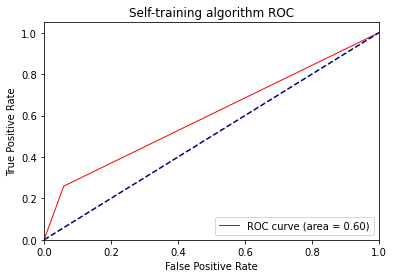

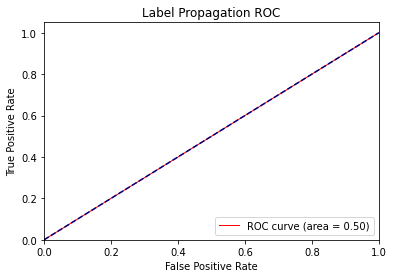

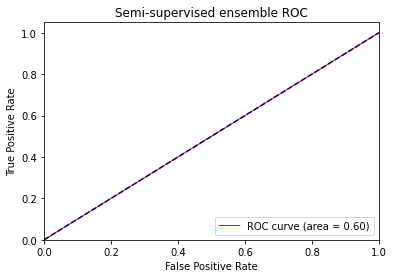

In [24]:
#Self-training algorithm
fpr, tpr, thresholds = roc_curve(H_testing_label, H_ST_RF_Pred)

roc_auc = auc(fpr, tpr)
plot.figure()
plot.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], color='navy', linestyle='--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Self-training algorithm ROC')
plot.legend(loc="lower right")
plot.show()

#Label Propagation
fpr2, tpr2, thresholds2 = roc_curve(H_testing_label, H_LP_Pred)

roc_auc2 = auc(fpr2, tpr2)
plot.figure()
plot.plot(fpr2, tpr2, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc2)
plot.plot([0, 1], [0, 1], color='navy', linestyle='--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Label Propagation ROC')
plot.legend(loc="lower right")
plot.show()

#Semi-supervised ensemble
fpr3, tpr3, thresholds3 = roc_curve(H_testing_label, H_SEE_Pred)

roc_auc3 = auc(fpr, tpr)
plot.figure()
plot.plot(fpr3, tpr3, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc3)
plot.plot([0, 1], [0, 1], color='navy', linestyle='--')
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Semi-supervised ensemble ROC')
plot.legend(loc="lower right")
plot.show()

f1-measure

In [23]:
#Self-training algorithm
CM_ST=confusion_matrix(H_testing_label, H_ST_RF_Pred)
print("#Self-training algorithm Confusion Matrix: \n",CM_ST)
print(classification_report(H_testing_label, H_ST_RF_Pred))

#Label Propagation
CM_LB=confusion_matrix(H_testing_label, H_LP_Pred)
print("#Label Propagation Confusion Matrix: \n",CM_LB)
print(classification_report(H_testing_label, H_LP_Pred))

#Semi-supervised ensemble
CM_SSE=confusion_matrix(H_testing_label, H_SEE_Pred)
print("#Semi-supervised ensemble Confusion Matrix: \n",CM_SSE)
print(classification_report(H_testing_label, H_SEE_Pred))


#Self-training algorithm Confusion Matrix: 
 [[32  2]
 [20  7]]
              precision    recall  f1-score   support

         0.0       0.62      0.94      0.74        34
         1.0       0.78      0.26      0.39        27

    accuracy                           0.64        61
   macro avg       0.70      0.60      0.57        61
weighted avg       0.69      0.64      0.59        61

#Label Propagation Confusion Matrix: 
 [[34  0]
 [27  0]]
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72        34
         1.0       0.00      0.00      0.00        27

    accuracy                           0.56        61
   macro avg       0.28      0.50      0.36        61
weighted avg       0.31      0.56      0.40        61

#Semi-supervised ensemble Confusion Matrix: 
 [[ 0  0  0]
 [34  0  0]
 [27  0  0]]
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       0.0
         0.0       0.00      0.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat